# Mean squared error boosting

In [1]:
from support import *

In [2]:
df = data()
df

,sqfeet,rent
0,750,1160
1,800,1175
2,850,1200
3,900,1250
4,950,2000


In [3]:
eta = 1.0
M = 3
gbm = l2boost(df, 'rent', eta, M)
splits = gbm.splits()
print(gbm.splits())

df['deltas'] = df[['delta1','delta2','delta3']].sum(axis=1) # sum deltas

df

[925.0, 825.0, 925.0]


,sqfeet,rent,F0,res1,delta1,F1,res2,delta2,F2,res3,delta3,F3,deltas
0,750,1160,1357.0,-197.0,-160.75,1196.25,-36.25,-28.750000,1167.500000,-7.500000,4.791667,1172.291667,-184.708333
1,800,1175,1357.0,-182.0,-160.75,1196.25,-21.25,-28.750000,1167.500000,7.500000,4.791667,1172.291667,-184.708333
2,850,1200,1357.0,-157.0,-160.75,1196.25,3.75,19.166667,1215.416667,-15.416667,4.791667,1220.208333,-136.791667
3,900,1250,1357.0,-107.0,-160.75,1196.25,53.75,19.166667,1215.416667,34.583333,4.791667,1220.208333,-136.791667
4,950,2000,1357.0,643.0,643.00,2000.00,0.00,19.166667,2019.166667,-19.166667,-19.166667,2000.000000,643.000000


In [4]:
def mse(df, M):
    return np.array([mean_squared_error(df.rent, df['F'+str(s)]) for s in range(M+1)])

def mae(df, M):
    return np.array([mean_absolute_error(df.rent, df['F'+str(s)]) for s in range(M+1)])

np.set_printoptions(precision=3)
print(mse(df, M))
print(np.sqrt(mse(df, M)))
print(mae(df, M))

[104296.       933.75     382.708    290.868]
[322.949  30.557  19.563  17.055]
[257.2    23.     16.833  13.   ]


In [5]:
F = df[['sqfeet','rent','F0','F1','F2','F3']]
for i in range(len(F)):
    print( " & ".join([f"{int(v)}" for v in F.iloc[i,0:6]]), r"\\")

750 & 1160 & 1357 & 1196 & 1167 & 1172 \\
800 & 1175 & 1357 & 1196 & 1167 & 1172 \\
850 & 1200 & 1357 & 1196 & 1215 & 1220 \\
900 & 1250 & 1357 & 1196 & 1215 & 1220 \\
950 & 2000 & 1357 & 2000 & 2019 & 2000 \\


In [6]:
# manually print table in python
# for small phone, make 2 tables
for i in range(len(df)):
    print( " & ".join([f"{int(v)}" for v in df.iloc[i,0:4]]), r"\\")

print
for i in range(len(df)):
    print( " & ".join([f"{int(v)}" for v in df.iloc[i,4:]]), r"\\")

750 & 1160 & 1357 & -197 \\
800 & 1175 & 1357 & -182 \\
850 & 1200 & 1357 & -157 \\
900 & 1250 & 1357 & -107 \\
950 & 2000 & 1357 & 643 \\
-160 & 1196 & -36 & -28 & 1167 & -7 & 4 & 1172 & -184 \\
-160 & 1196 & -21 & -28 & 1167 & 7 & 4 & 1172 & -184 \\
-160 & 1196 & 3 & 19 & 1215 & -15 & 4 & 1220 & -136 \\
-160 & 1196 & 53 & 19 & 1215 & 34 & 4 & 1220 & -136 \\
643 & 2000 & 0 & 19 & 2019 & -19 & -19 & 2000 & 642 \\


## Plot F0 vs rent

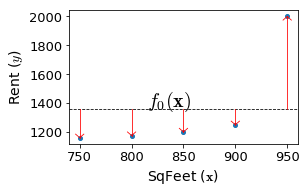

In [7]:
f0 = df.rent.mean()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2.5), sharex=True)
plt.tight_layout()
ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
ax.text(815, f0+15, r"$f_0({\bf x})$", fontsize=20)

ax.set_ylabel(r"Rent ($y$)", fontsize=14)
ax.set_xlabel(r"SqFeet (${\bf x}$)", fontsize=14)

# draw arrows
for x,y,yhat in zip(df.sqfeet,df.rent,df.F0):
    draw_vector(ax, x, yhat, 0, y-yhat, df.rent.max()-df.rent.min())

plt.show()

## Plot delta predictions versus residuals

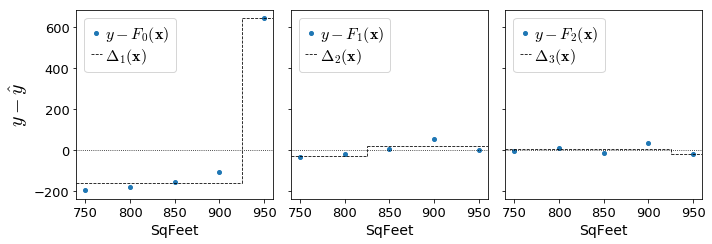

In [8]:
def draw_stump(ax, x_train, y_train, y_pred, split, stage):
    line1, = ax.plot(x_train, y_train, 'o',
                     markersize=4,
                     label="$y-F_"+str(stage-1)+"({\\bf x})$")
    label = r"$\Delta_"+str(stage)+r"({\bf x})$"
    left = y_pred[x_train<split]
    right = y_pred[x_train>split]
    lmean = np.mean(left)
    rmean = np.mean(right)
    line2, = ax.plot([x_train.min()-10,split], [lmean,lmean],
             linewidth=.8, linestyle='--', c='k', label=label)
    ax.plot([split,x_train.max()+10], [rmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    ax.plot([split,split], [lmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    ax.plot([x_train.min()-10,x_train.max()+10], [0,0],
             linewidth=.8, linestyle=':', c='k')
    ax.legend(handles=[line1,line2], fontsize=16,
              loc='upper left', 
              labelspacing=.1,
              handletextpad=.2,
              handlelength=.7,
              frameon=True)

def draw_residual(ax, x_train, y_train, y_hat):
    for x,y,yhat in zip(x_train, y_train, y_hat):
        draw_vector(ax, x, yhat, 0, y-yhat, df.rent.max()-df.rent.min())

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharey=True)

axes[0].set_ylabel(r"$y-\hat y$", fontsize=20)
for a in range(3):
    axes[a].set_xlabel(r"SqFeet", fontsize=14)
    axes[a].set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)

draw_stump(axes[0], df.sqfeet, df.res1, df.delta1, splits[0], stage=1)

draw_stump(axes[1], df.sqfeet, df.res2, df.delta2, splits[1], stage=2)

draw_stump(axes[2], df.sqfeet, df.res3, df.delta3, splits[2], stage=3)

plt.tight_layout()
        
plt.savefig('/tmp/t.svg')
plt.show()

In [9]:
df[['delta1','delta2','delta3']]

,delta1,delta2,delta3
0,-160.75,-28.750000,4.791667
1,-160.75,-28.750000,4.791667
2,-160.75,19.166667,4.791667
3,-160.75,19.166667,4.791667
4,643.00,19.166667,-19.166667


## Show MSE for various learning rates

In [10]:
M = 4

df_mse = pd.DataFrame(data={"stage":range(M+1)})

for eta in np.arange(.5, 1, .1):
    df = data() # fresh data
    gbm = l2boost(df, 'rent', eta, M)
    
    df_mse[f'mse_{eta:.2f}'] = mse(df, M)

df_mse

,stage,mse_0.50,mse_0.60,mse_0.70,mse_0.80,mse_0.90
0,0,104296.000000,104296.000000,104296.000000,104296.000000,104296.000000
1,1,26774.312500,17471.710000,10236.352500,5068.240000,1967.372500
2,2,7393.890625,3579.823600,1770.984225,1099.129600,251.553897
3,3,2548.785156,1180.583666,339.461973,245.554944,117.861620
4,4,923.394409,330.955072,83.300445,87.747750,93.742386


[923.3944091796893, 330.95507170999997, 83.30044475120413, 87.74775011555509, 93.74238635453273]
Best index is  2 0.7


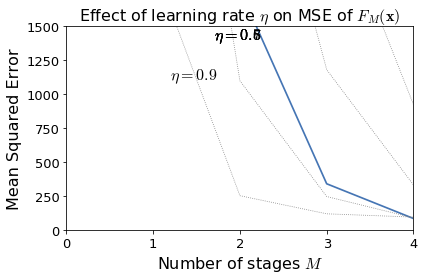

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex=True)

maxy = 1500

max_eta = 1
min_eta = .5
mins = []
for eta in np.arange(min_eta, max_eta, .1):
    mins.append( np.min(df_mse[f'mse_{eta:.2f}']) )

print (mins)
min_eta_index = np.argmin(mins)
print("Best index is ", min_eta_index, list(np.arange(min_eta, max_eta, .1))[min_eta_index])

i = 0
for eta in np.arange(min_eta, max_eta, .1):
    color = 'grey'
    lw = .8
    ls = ':'
    if i==min_eta_index:
        color = bookcolors['blue']
        lw = 1.7
        ls = '-'
    ax.plot(df_mse.stage,df_mse[f'mse_{eta:.2f}'],
            linewidth=lw,
            linestyle=ls,
            c=color)
    xloc = 1.2
    yloc = (df_mse[f'mse_{eta:.2f}'].values[1] + df_mse[f'mse_{eta:.2f}'].values[2])/2
    if yloc>maxy:
        yloc = maxy-100
        xloc +=  .5
    ax.text(xloc, yloc, f"$\\eta={eta:.1f}$",
            fontsize=16)
    i += 1

plt.axis([0,M,0,maxy])

ax.set_ylabel(r"Mean Squared Error", fontsize=16)
ax.set_xlabel(r"Number of stages $M$", fontsize=16)
ax.set_title(r'Effect of learning rate $\eta$ on MSE of $F_M({\bf x})$', fontsize=16)
ax.set_xticks(range(0,M+1))

plt.tight_layout()
plt.show()

## Show composite model

In [12]:
# Hideous manual computation of composite graph but...

M = 3
eta = 1.0
df = data()
gbm = l2boost(df, 'rent', eta, M)
df['deltas12'] = 0.7 * df[['delta1','delta2']].sum(axis=1)
df['deltas123'] = 0.7 * df[['delta1','delta2','delta3']].sum(axis=1)
df['deltas'] = 0.7 * df[['delta1','delta2','delta3']].sum(axis=1) # sum deltas

df[['sqfeet','rent','F0','delta1','delta2','delta3','deltas','deltas12','deltas123']]

,sqfeet,rent,F0,delta1,delta2,delta3,deltas,deltas12,deltas123
0,750,1160,1357.0,-160.75,-28.750000,4.791667,-129.295833,-132.650000,-129.295833
1,800,1175,1357.0,-160.75,-28.750000,4.791667,-129.295833,-132.650000,-129.295833
2,850,1200,1357.0,-160.75,19.166667,4.791667,-95.754167,-99.108333,-95.754167
3,900,1250,1357.0,-160.75,19.166667,4.791667,-95.754167,-99.108333,-95.754167
4,950,2000,1357.0,643.00,19.166667,-19.166667,450.100000,463.516667,450.100000


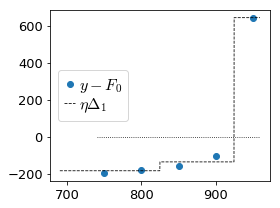

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

plot_deltas(ax, df, gbm, 1)

plt.tight_layout()
plt.show()

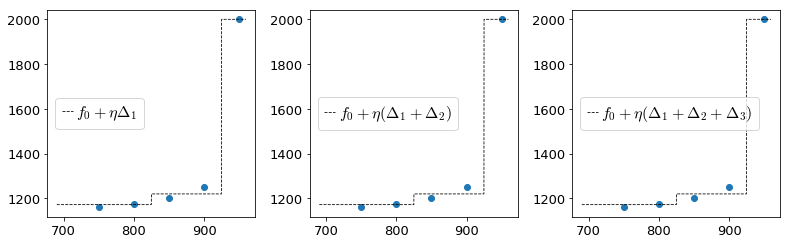

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11.1, 3.5))

plot_composite(axes[0], df, gbm, 1)
plot_composite(axes[1], df, gbm, 2)
plot_composite(axes[2], df, gbm, 3)

plt.tight_layout()
plt.savefig('/tmp/u.svg')
plt.show()